In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import uuid
from sortedcontainers import SortedList
import pandas as pd
from os.path import join

raw_data = []

for i in range(1, 101):
    raw_data.append([])
    raw_data[i-1] = pd.read_csv(join('taxi_traj_release', 'taxi_log_2008_by_id', str(i)+'.txt'), header=None)

data = [(p.iloc[1][0], np.array([p.iloc[1][2], p.iloc[1][3]])) for p in raw_data]

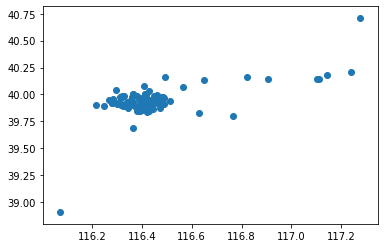

In [2]:
points = np.array([x[1] for x in data])
plt.scatter(points[:, 0], points[:, 1])

In [3]:
class KMeans:
    
    def __init__(self, k=3, tol=1e-4, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        
    def fit(self, data):
        self.centers = {}
        
        np.random.shuffle(data)
        for i in range(self.k):
            self.centers[i] = data[i][1]
        
        for i in range(self.max_iter):
            self.classifications = {}
            for j in range(self.k):
                self.classifications[j] = []
                
            for d in data:
                distances = [np.linalg.norm(d[1]-self.centers[c]) for c in self.centers]
                classification = np.argmin(distances)
                self.classifications[classification].append(d)
            
            prev_centers = dict(self.centers)
            for classification in self.classifications:
                self.centers[classification] = np.average(list(zip(*self.classifications[classification]))[1], axis=0)
            ok = True
            for c in self.centers:
                prev = prev_centers[c]
                cur = self.centers[c]
                if np.sum((prev-cur) / prev * 100.0) > self.tol:
                    ok = False
                    break
            if ok:
                break
        
def UB_Y(p, m_p, theta_p, M, delta):
    d1 = np.linalg.norm(p-m_p)
    cur_min = None
    for m in M:
        if np.array_equal(m, m_p):
            continue
        if cur_min==None:
            cur_min = np.linalg.norm(p, m)
        else:
            cur_min = min(cur_min, np.linalg.norm(p, m))
    return np.square(d1+delta+theta_p) - np.square(max(0, cur_min-delta-theta_p))

# P is a list of tuple (uuid, vector)
# m is a map from uuid of the point to the index of the point's corresponding center 
# (e.g. m[p_1]=2 means M[2] is m[p_1]'s clustering center)
# classifications is a map from the index of the center to the list of points belonging to this center
def compute_threshold(P, M, m, classifications, delta_1, delta_2):
    delta = delta_1 + delta_2
    Theta = {}
    P_move = []
    for p in P:
        Theta[p[0]] = delta_1
    for p in P:
        if UB_Y(p[1], M[m[p[0]]], Theta[p[0]], M, delta) < 0:
            P_move.append(p)
    ok = False
    while not ok:
        ok = True
        d_p = {}
        d_p_prime = {}
        for p in P_move:
            d_p[p[0]] = np.linalg.norm(p[1]-M[m[p[0]]])
            d_p_prime[p[0]] = None
            for i in range(len(M)):
                if i == m[p[0]]:
                    continue
                if d_p_prime[p[0]] == None:
                    d_p_prime[p[0]] = np.linalg.norm(p[1]-M[i])
                else:
                    d_p_prime[p[0]] = min(np.linalg.norm(p[1]-M[i]), d_p_prime[p[0]])
        for p in P_move:
            # Decrease theta_p so that it satisfies theta_p <= minm∈M\{mp}dist(p,m)−Δ
            Theta[p[0]] = d_p_prime[p[0]] - delta
            # Let theta_p_aster be results of evaluating Equation 4.11
            sum_1 = np.sum([np.sqrt(d_p[q[0]]+d_p_prime[q[0]]) for q in P_move])
            sum_2 = np.sum([np.square(d_p[q[0]]+delta)-np.square(d_p_prime[q[0]]-delta) for q in P_move])
            min_cardi = np.min([len(x) for x in classifications.values()])
            theta_p_aster = np.sqrt(d_p[p[0]]-d_p_prime[p[0]])/(2*(d_p[p[0]]+d_p_prime[p[0]])*sum_1)*(min_cardi*np.square(delta_2)-sum_2)
            if theta_p_aster < Theta[p[0]]:
                Theta[p[0]] = theta_p_aster
        for p in P_move:
            if UB_Y(p[1], M[m[p[0]]], Theta[p[0]], M, delta) <= 0:
                P_move.remove(p)
                ok = False
        return Theta

(115.99976829349134, 117.33906934808631, 38.7835252453507, 40.80834942548727)

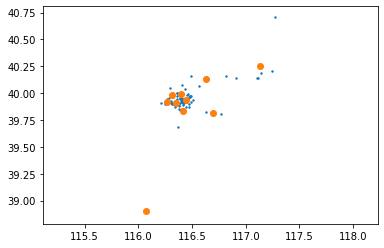

In [4]:
model = KMeans(k=10)
model.fit(data)

centers = np.array([val for val in model.centers.values()])

m = {}
for index in model.classifications:
    for p in model.classifications[index]:
        m[p[0]] = index
        
plt.scatter(points[:, 0], points[:, 1], s=2)
plt.scatter(centers[:, 0], centers[:, 1])
plt.axis('equal')

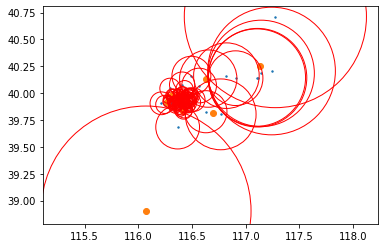

In [5]:
import warnings; warnings.simplefilter('ignore')
accu = 1000 # in meters
thresholds = compute_threshold(data, model.centers, m, model.classifications, accu / 111000, accu / 111000)

plt.scatter(points[:, 0], points[:, 1], s=2)
plt.scatter(centers[:, 0], centers[:, 1])
plt.axis('equal')
ax = plt.gca()
dict_data = dict(data)
for k in thresholds:
    ax.add_artist(plt.Circle(dict_data[k], thresholds[k], color='r', fill=False))

In [6]:
from json import dumps
result = {}
for d in data:
    result[int(d[0])] = {'coord': dict_data[d[0]].tolist(), 'thres': thresholds[d[0]]}
result = {'centers': centers.tolist(), 'classification': result}
json_string = dumps(result, sort_keys=True)
f = open("sample.json", "w+")
f.write(json_string)
f.close()